This notebook generates the stress histograms of different voter types. So, are republicans or democrats more stressed?

In [130]:
""" BORING!!! """
import numpy as np
import pyreadstat as prs
import sys
sys.path.append('../src')
from clean_data_1 import transform_dataframe_1
from clean_data_2 import transform_dataframe_2
from make_belief_network import make_belief_network
from calc_stress import stress
from interpret_belief_vector import interpret_belief_vector

In [131]:
""" Importing the data!!! """
import pyreadstat as prs
raw_df, meta = prs.read_sas7bdat("../dat/gss7222_r3.sas7bdat")

In [132]:
""" Cleaning the data and setting the replicating core """
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../src')
from clean_data_1 import transform_dataframe_1
 
# Clean data 
df, metadata = transform_dataframe_1(raw_df)    

# Set variables of interest
variables = ["PARTYID","POLVIEWS","NATSPAC","NATENVIR","NATHEAL","NATCITY","NATCRIME","NATDRUG","NATEDUC","NATRACE","NATARMS",
"NATAID","NATFARE","NATROAD","NATSOC","NATMASS","NATPARK","NATCHLD","NATSCI","EQWLTH","SPKATH","COLATH","LIBATH","SPKRAC","COLRAC","LIBRAC","SPKCOM","COLCOM","LIBCOM","SPKMIL","COLMIL","LIBMIL","SPKHOMO",
"COLHOMO","LIBHOMO","SPKMSLM","COLMSLM","LIBMSLM","CAPPUN","GUNLAW","COURTS","GRASS","ATTEND","RELITEN","POSTLIFE","PRAYER","AFFRMACT","WRKWAYUP","HELPFUL",
"FAIR","TRUST","CONFINAN","CONBUS","CONCLERG","CONEDUC","CONFED","CONLABOR","CONPRESS","CONMEDIC","CONTV","CONJUDGE","CONSCI","CONLEGIS","CONARMY","GETAHEAD","FEPOL","ABDEFECT","ABNOMORE","ABHLTH","ABPOOR","ABRAPE","ABSINGLE","ABANY","SEXEDUC","DIVLAW","PREMARSX","TEENSEX","XMARSEX","HOMOSEX","PORNLAW",
"SPANKING","LETDIE1","SUICIDE1","SUICIDE2","POLHITOK","POLABUSE","POLMURDR","POLESCAP","POLATTAK","NEWS","TVHOURS","FECHLD","FEPRESCH","FEFAM","RACDIF1","RACDIF2","RACDIF3",
"RACDIF4","HELPPOOR","MARHOMO", "PRESLAST_NONCONFORM", "PRESLAST_DEMREP", "VOTELAST"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [216]:

start_year = 1990
timeframe = list(range(start_year, start_year+8))

BN, variables_list, correlation_matrix_partial = make_belief_network(df, variables, timeframe, method="spearman", is_partial=True, threshold=0, sample_threshold=0, regularisation=0.2)



In [249]:
""" In order to calculate the stress of beleif vectors, we need to belief vectors """
""" We first clear the dataset again to implement the median solution """

df_b_vecs, _ = transform_dataframe_2(df, timeframe)

""" We can then cut the data down to only the variables in the belief network """

df_b_vecs = df_b_vecs[variables_list]

""" And then split into republicans and democrats via the PARTYID variable """

""" Interesting variables: "SPKATH","COLATH","LIBATH","SPKRAC","COLRAC","LIBRAC","SPKCOM","COLCOM","LIBCOM","SPKMIL","COLMIL","LIBMIL","SPKHOMO",
"COLHOMO","LIBHOMO","SPKMSLM","COLMSLM","LIBMSLM" """

var_for_split = "LIBRAC"

print(df[var_for_split].value_counts())
print(df_b_vecs[var_for_split].value_counts())

df_repub_vecs = df_b_vecs[df_b_vecs[var_for_split] < 0]
df_demo_vecs = df_b_vecs[df_b_vecs[var_for_split] > 0]


""" And then get arrays for the belief vectors """

belief_vectors_repub = df_repub_vecs.to_numpy()
belief_vectors_dem = df_demo_vecs.to_numpy()

""" Finally we want to set the NaNs to zero, and normalise the vectors such that they span -1 and 1 """
belief_vectors_repub[np.isnan(belief_vectors_repub)] = 0
belief_vectors_dem[np.isnan(belief_vectors_dem)] = 0


epsilon = 1e-10
belief_vectors_repub = 2 * (belief_vectors_repub - np.min(belief_vectors_repub, axis=0)) / (np.max(belief_vectors_repub, axis=0) - np.min(belief_vectors_repub, axis=0) + epsilon) - 1
belief_vectors_dem = 2 * (belief_vectors_dem - np.min(belief_vectors_dem, axis=0)) / (np.max(belief_vectors_dem, axis=0) - np.min(belief_vectors_dem, axis=0) + epsilon) - 1

# Check for any NaNs and print them
print(np.isnan(belief_vectors_repub).sum())
print(np.isnan(belief_vectors_dem).sum())



LIBRAC
-1.0    24588
 1.0    13462
Name: count, dtype: int64
LIBRAC
-1.0    4469
 1.0    2185
Name: count, dtype: int64
0
0


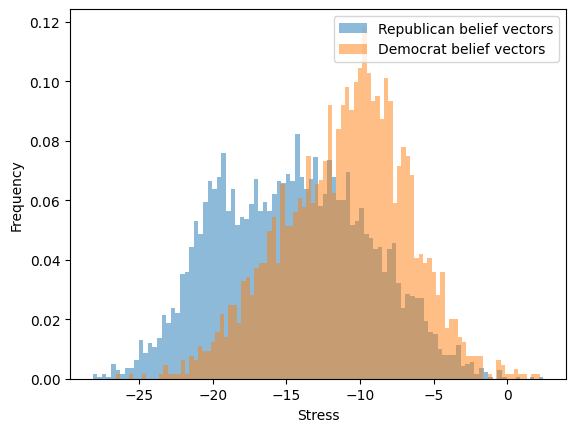

Number of belief vectors:  6654


In [257]:
""" Okay, and now we calculate the stress of the belief vectors """

correlation_matrix_noDiag = correlation_matrix_partial - np.eye(correlation_matrix_partial.shape[0])

repub_stress_vec = []
dem_stress_vec = []

repub_stress_vec = [stress(belief_vectors_repub[i,:], correlation_matrix_noDiag) for i in range(belief_vectors_repub.shape[0])]
dem_stress_vec = [stress(belief_vectors_dem[i,:], correlation_matrix_noDiag) for i in range(belief_vectors_dem.shape[0])]

summed_stress_vec = repub_stress_vec + dem_stress_vec

""" We can also compare it to a random set of belief vectors """

# Generate K random belief vectors
# random_belief_vectors = np.random.choice([-1, 0, 1], size=(len(stress_vec), len(variables_list)))
# alt_belief_vectors = np.random.rand(len(repub_stress_vec)+len(dem_stress_vec), len(variables_list))*2 - 1
# alt_stress_vec = [stress(vector, correlation_matrix_partial) for vector in random_belief_vectors]

""" We can also compare the stress vectors of republican and democrat belief vectors """



import matplotlib.pyplot as plt
# plt.hist(summed_stress_vec, bins=100, alpha=0.3, label='Summed belief vectors')
plt.hist(repub_stress_vec, bins=100, alpha=0.5, label='Republican belief vectors', density=True)
plt.hist(dem_stress_vec, bins=100, alpha=0.5, label='Democrat belief vectors', density=True)
plt.legend(loc='upper right')
plt.xlabel('Stress')
plt.ylabel('Frequency')
plt.show()

print("Number of belief vectors: ", len(summed_stress_vec))